# Decision response delay

## 1. Initial $y_0$ concentration dependency

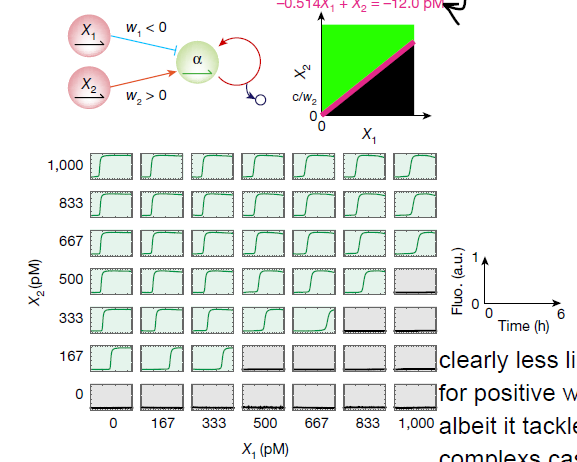

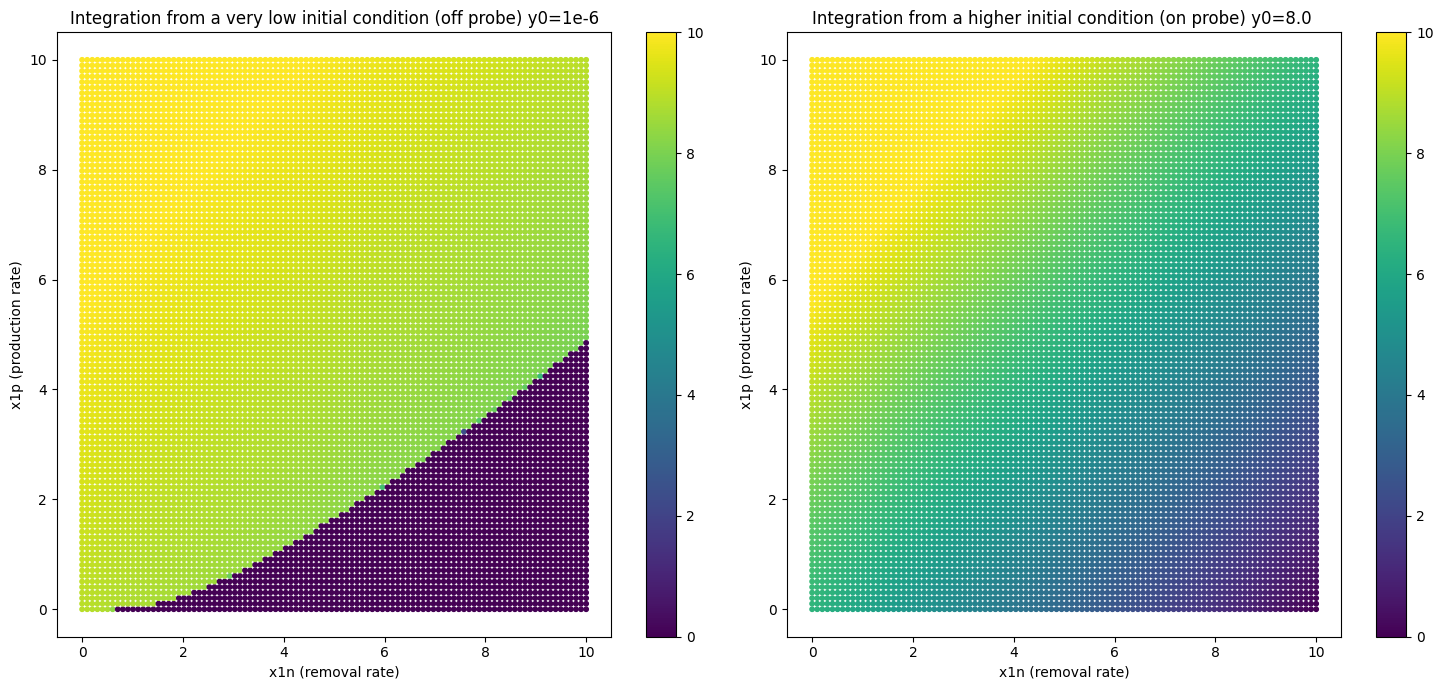

The system display tree fixed points (one unstable steady state in the middle (e.g., a saddle point) and 2 stable steady states located on either side (low and high branches). If we start close to the low one (e.g., y0=1e-6), the system will relax to the low steady state (i.e. the rule "choose the lowest fixed point", when no ambiguity is probed). If we start close to the high branch (e.g., y0=8.0), the system will relax to the high steady state (i.e. the rule "choose the highest fixed point", when no ambiguity is probed). Nevertheless, the physical case is the first one, as y being a product of the CRN, we always start from low values of $y_0$.

On the second plot, we can see that starting from a non 0 concentration of $y_0$ completely destroy the networks ability to classifie the space : indeed, we don't start from a given state (off/on) but from an ambiguous mixture.

## 2. Classification time efficiency of the CRN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm  # For progress bar
from itertools import product
from matplotlib.collections import LineCollection

# --- Parameters ---
delta = 0.1
k_s = 0.02
b = 0.005

# ODE definition
def dy_dt(t, y, delta, x1p, x1n, k_s):
    return y / (1 + y) - delta * y + 0.017 * x1p - (y * (b + 0.017 * x1n)) / (k_s + y)

# Integration helper function
def integrate_ode(x1p, x1n, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(dy_dt, t_span, [y0],
                    args=(delta, x1p, x1n, k_s),
                    t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    return sol.y[0, -1]

# Correct Discriminant Function Δ(x1n, x1p)
def discriminant(x1p, x1n):
    return (0.000135648
            + 8.3521e-8 * x1n**4
            + x1n**3 * (-0.0000108676 - 3.30743e-7 * x1p)
            + x1n**2 * (0.00024844 + (0.0000318443 + 4.91137e-7 * x1p) * x1p)
            + x1n * (-0.000361051 + x1p * (-0.00044181 + (-0.0000310883 - 3.24128e-7 * x1p) * x1p))
            + x1p * (-0.000607421 + x1p * (0.000193247 + (0.0000101115 + 8.02136e-8 * x1p) * x1p)))

# --- Parameter grid for numerical integration (for the full phase diagram) ---
nb_of_points = 100
x1p_values = np.linspace(0, 10, nb_of_points)
x1n_values = np.linspace(0, 10, nb_of_points)
t_span_full = (0, 100)
y0=1e-6 #initial concentration

results = []
for x1p, x1n in tqdm(product(x1p_values, x1n_values), total=len(x1p_values)*len(x1n_values)):
    # Solve for the low initial value
    y_low = integrate_ode(x1p, x1n, y0, t_span=t_span_full)
    # Clip y_low into a reasonable range (0 to 10) for visualization
    results.append((x1p, x1n, np.clip(y_low, 0, 10)))
results = np.array(results)
x1p_plot = results[:, 0]
x1n_plot = results[:, 1]
y_low_plot = results[:, 2]




  0%|          | 0/10000 [00:00<?, ?it/s]

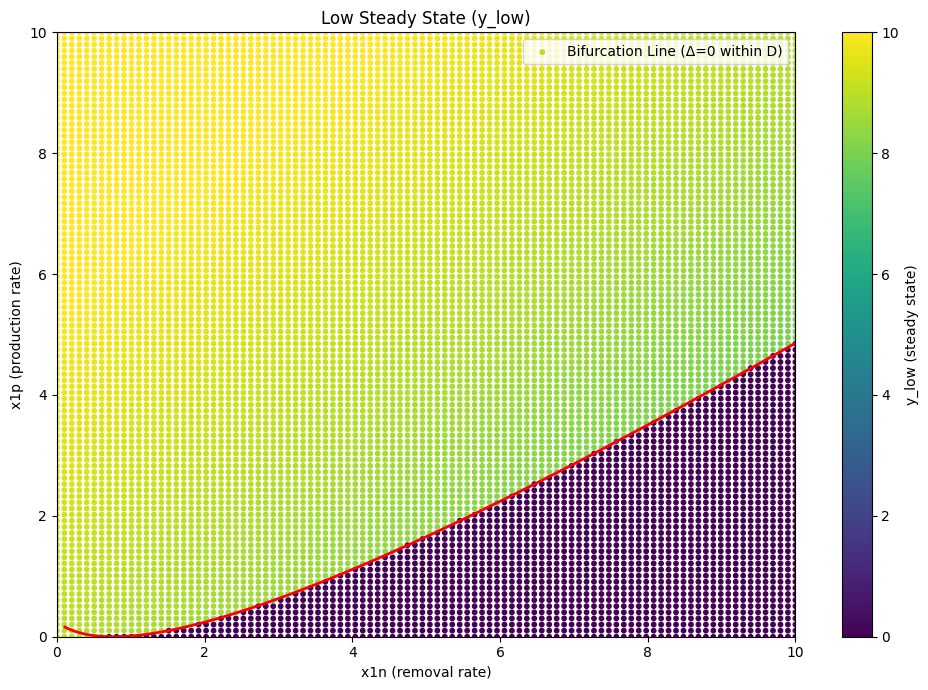

In [2]:
# --- Plot the phase diagram with bifurcation line ---
fig, ax = plt.subplots(figsize=(10, 7))

a = 2  # Domain condition parameter: x1p - a*x1n < 0

sc = ax.scatter(x1n_plot, x1p_plot, c=y_low_plot, cmap='viridis', s=10, marker='o')
ax.set_title("Low Steady State (y_low)")
ax.set_xlabel("x1n (removal rate)")
ax.set_ylabel("x1p (production rate)")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("y_low (steady state)")

# Overlay bifurcation line (Δ(x1n, x1p) = 0) for lower branch
x1n_vals = np.linspace(0, 10, 1000)
x1p_vals = np.linspace(0, 10, 1000)
X1N, X1P = np.meshgrid(x1n_vals, x1p_vals)
delta_vals = discriminant(X1P, X1N)
domain_mask = (X1P - a * X1N) < 0
delta_vals_masked = np.ma.array(delta_vals, mask=~domain_mask)
contour = ax.contour(X1N, X1P, delta_vals_masked, levels=[0], colors='r', linewidths=2)
ax.legend(["Bifurcation Line (Δ=0 within D)"])
plt.tight_layout()
plt.show()



Rmk : We shall keep in mind that the analytical contour and the time simulation are just both come from the same chemical kinetic equation.


Let us now study the y density profile along the $(0,10)\rightarrow(10,0)$ diagonal, as a function of the computation time of the CRN. 

Processing tf values:   0%|          | 0/5 [00:00<?, ?it/s]

tf = 2:   0%|          | 0/100 [00:00<?, ?it/s]

tf = 10:   0%|          | 0/100 [00:00<?, ?it/s]

tf = 40:   0%|          | 0/100 [00:00<?, ?it/s]

tf = 100:   0%|          | 0/100 [00:00<?, ?it/s]

tf = 200:   0%|          | 0/100 [00:00<?, ?it/s]

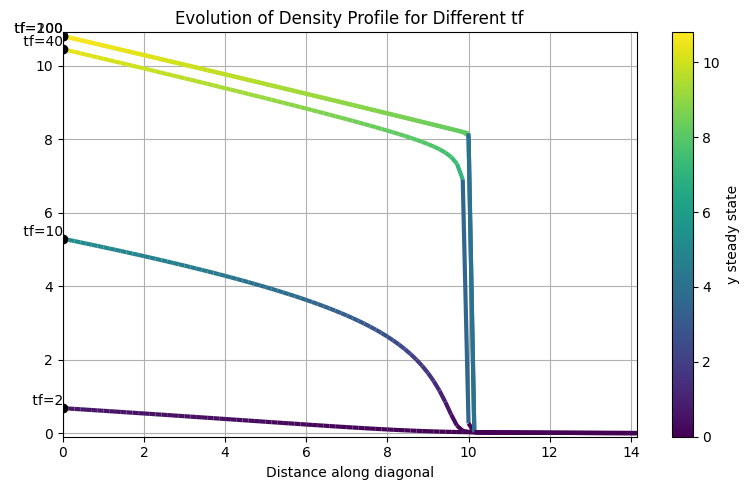

In [3]:
# -----------------------------------------------------------------
# Study the Evolution of the Density Profile as a Function of tf
# -----------------------------------------------------------------

# Parameterize the diagonal from (0,10) to (10,0):
#   Using parameter t in [0, 1]:
#      x1n = 10*t,    x1p = 10*(1-t)
num_points = 100
t_line = np.linspace(0, 1, num_points)
x1n_diag = 10 * t_line
x1p_diag = 10 * (1 - t_line)
# Compute physical distance along the diagonal: L = 10*sqrt(2)*t
distance_diag = 10 * np.sqrt(2) * t_line

# Define a set of final integration times tf to study
tf_list = [2,10, 40, 100, 200]

# Compute the density profiles along the diagonal for each tf
profiles = {}
for tf in tqdm(tf_list, desc="Processing tf values"):
    y_profile = np.zeros(num_points)
    for i in tqdm(range(num_points), desc=f"tf = {tf}", leave=False):
        # Use the current final time tf in integration
        y_profile[i] = integrate_ode(x1p_diag[i], x1n_diag[i], y0=1e-6, t_span=(0, tf))
    profiles[tf] = y_profile

# Determine the global min and max among profiles for color mapping the y-values
all_y = np.concatenate(list(profiles.values()))
y_min, y_max = all_y.min(), all_y.max()
norm_y = plt.Normalize(vmin=y_min, vmax=y_max)
cmap_y = plt.cm.viridis

# --------------------------------------------
# Plot using LineCollection for Density Profiles,
# with segments colored by local y values and annotate left endpoints with tf.
# --------------------------------------------
fig2, ax2 = plt.subplots(figsize=(8, 5))
for tf in tf_list:
    y_profile = profiles[tf]
    # Build points array for the profile: shape (num_points, 2)
    points = np.array([distance_diag, y_profile]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Assign colors to each segment based on the average y value
    seg_colors = []
    for i in range(len(segments)):
        y_seg_avg = (y_profile[i] + y_profile[i+1]) / 2.0
        seg_colors.append(cmap_y(norm_y(y_seg_avg)))
        
    # Create and add the LineCollection for this profile
    lc = LineCollection(segments, colors=seg_colors, linewidths=3)
    ax2.add_collection(lc)
    
    # Annotate the left endpoint (i.e. at the beginning of the diagonal)
    left_distance = distance_diag[0]
    left_y = y_profile[0]
    ax2.plot(left_distance, left_y, 'ko', markersize=6)
    ax2.text(left_distance, left_y, f' tf={tf}', fontsize=10, va='bottom', ha='right')

ax2.set_xlim(distance_diag.min(), distance_diag.max())
ax2.set_ylim(all_y.min()-0.1, all_y.max()+0.1)
ax2.set_xlabel("Distance along diagonal")
ax2.set_title("Evolution of Density Profile for Different tf")
ax2.grid(True)

# Add colorbar for the y values (density)
sm = plt.cm.ScalarMappable(cmap=cmap_y, norm=norm_y)
sm.set_array([])
cbar2 = plt.colorbar(sm, ax=ax2)
cbar2.set_label("y steady state")
plt.tight_layout()
plt.show()

Early stopping ($t_f=2,...,10,...$) of the CRN computation freeze most of neurons/dropplets in an undecized state (wich is the off one as we start from low $y_0$ values).Therefore, the classification frontiere ends up blurry if not completely absent. Increasing the computation time leads the frontier to converges toward a treshold value : the whole system reaches a stable/decided state for classification.

We can try to get an idea of the order neaded for all neuron to have reached their decided/steady state.

Integrating y(t):   0%|          | 0/10000 [00:00<?, ?it/s]

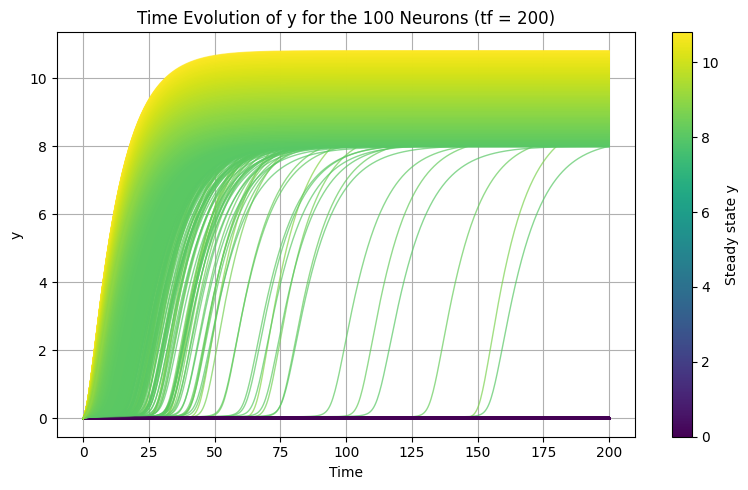

In [4]:
# -----------------------------------------------------------------
# Plot y(t) for all neurons (entire grid) from t=0 to a single tf value
# to visualize convergence speed to the classified state.
# -----------------------------------------------------------------

# Choose a single final time for the integration
tf_single = 200
t_eval_single = np.linspace(0, tf_single, 500)

# Define the grid of neurons (if not already defined):
nb_of_points_grid = 100
x1p_values = np.linspace(0, 10, nb_of_points_grid)
x1n_values = np.linspace(0, 10, nb_of_points_grid)
all_neurons = [(x1p, x1n) for x1p in x1p_values for x1n in x1n_values]

fig5, ax5 = plt.subplots(figsize=(8, 5))

# Loop over the grid to compute and plot y(t) for each neuron.
for x1p, x1n in tqdm(all_neurons, total=len(all_neurons), desc="Integrating y(t)"):
    sol = solve_ivp(dy_dt, (0, tf_single), [1e-6],
                    args=(delta, x1p, x1n, k_s),
                    t_eval=t_eval_single,
                    method="RK45", rtol=1e-8, atol=1e-10)
    y_vals = sol.y[0]
    
    # Color according to the steady state value (final y value)
    color = cmap_y(norm_y(y_vals[-1]))
    ax5.plot(sol.t, y_vals, color=color, lw=1, alpha=0.7)

ax5.set_xlabel("Time")
ax5.set_ylabel("y")
ax5.set_title(f"Time Evolution of y for the {nb_of_points_grid } Neurons (tf = {tf_single})")
ax5.grid(True)

# Add a colorbar for the final y values which indicate the classified state
sm = plt.cm.ScalarMappable(cmap=cmap_y, norm=norm_y)
sm.set_array([])
cbar5 = plt.colorbar(sm, ax=ax5)
cbar5.set_label("Steady state y")

plt.tight_layout()
plt.show()



We've ploted here the concentration of y for all neurons as a function of time. An approximation of such a time for the CRN (N=50) to fully operate the classification would be of the ordre of $\tau\approx 125$. It seems that the more you add neuron, the longer it takes to be sure that all neurons have reached their decided/steady state value, yet it is a purely stochastic artifact, as physically expected.

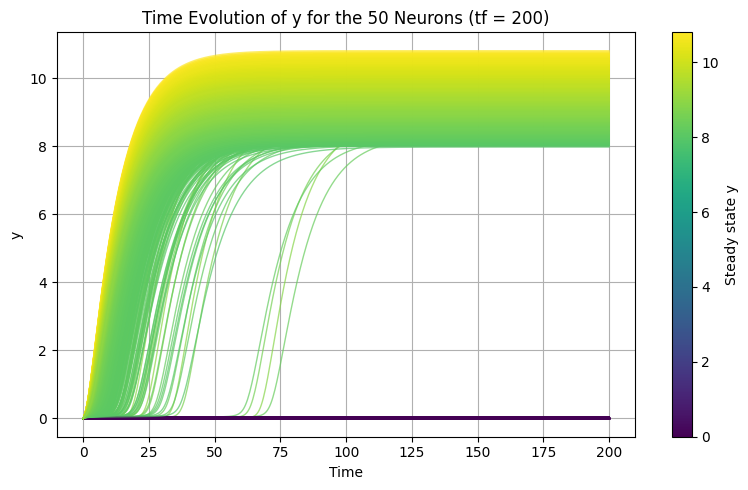 
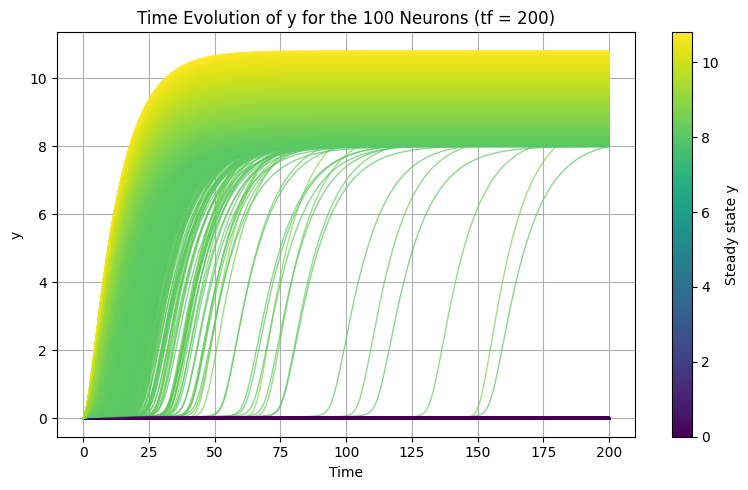

Rmk : up to now, we've used the following time unit $\tau=t(sc)V\cdot aT/K$ with V, K and aT are respectively - for the autocathalytic process - the turnover number (inverse of a time), K the Michaelis constant (concentration) and aT the autocathalitic template concentration, involved in $\alpha'(t)=\frac{V aT \alpha(t)}{K+\alpha(t)}+ \text{other processes}$


Processing grid with nb_of_points_grid = 30 (total neurons: 900)


Integrating for grid 30:   0%|          | 0/900 [00:00<?, ?it/s]

Grid size 30: 95% convergence reached at t ≈ 88.18

Processing grid with nb_of_points_grid = 60 (total neurons: 3600)


Integrating for grid 60:   0%|          | 0/3600 [00:00<?, ?it/s]

Grid size 60: 95% convergence reached at t ≈ 88.22

Processing grid with nb_of_points_grid = 120 (total neurons: 14400)


Integrating for grid 120:   0%|          | 0/14400 [00:00<?, ?it/s]

Grid size 120: 95% convergence reached at t ≈ 88.18

Processing grid with nb_of_points_grid = 240 (total neurons: 57600)


Integrating for grid 240:   0%|          | 0/57600 [00:00<?, ?it/s]

Grid size 240: 95% convergence reached at t ≈ 88.18


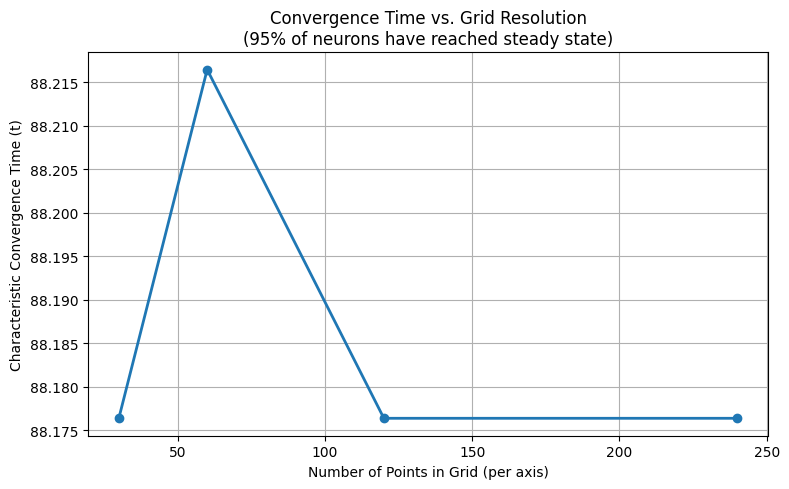

In [5]:
# Define the range of grid resolutions to explore
grid_sizes = [30,60,120,240]
char_times = []  # Will store the characteristic convergence time for each grid resolution

# Loop over the different grid resolutions
for nb_points in grid_sizes:
    # Define the grid of neurons for the current grid resolution
    x1p_values = np.linspace(0, 10, nb_points)
    x1n_values = np.linspace(0, 10, nb_points)
    all_neurons = [(x1p, x1n) for x1p in x1p_values for x1n in x1n_values]
    
    # Set up integration parameters
    tf_single = 400
    t_eval_single = np.linspace(0, tf_single, 500)
    
    tol = 1e-2  # tolerance for convergence
    convergence_times = []  # list to store convergence time for each neuron

    print(f"\nProcessing grid with nb_of_points_grid = {nb_points} (total neurons: {len(all_neurons)})")
    
    # Loop over each neuron and compute its convergence time
    for x1p, x1n in tqdm(all_neurons, total=len(all_neurons), desc=f"Integrating for grid {nb_points}"):
        sol = solve_ivp(dy_dt, (0, tf_single), [1e-6],
                        args=(delta, x1p, x1n, k_s),
                        t_eval=t_eval_single,
                        method="RK45", rtol=1e-8, atol=1e-10)
        y_vals = sol.y[0]
        y_final = y_vals[-1]
        conv_time = tf_single  # default if no earlier time meets the criterion
        for t_val, y_val in zip(sol.t, y_vals):
            if abs(y_val - y_final) < tol:
                conv_time = t_val
                break
        convergence_times.append(conv_time)
    
    # Compute the 95th percentile convergence time for this grid
    grid_char_time = np.percentile(convergence_times, 95)
    char_times.append(grid_char_time)
    print(f"Grid size {nb_points}: 95% convergence reached at t ≈ {grid_char_time:.2f}")

# Plot the characteristic convergence time as a function of the grid resolution.
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(grid_sizes, char_times, marker="o", lw=2)
ax.set_xlabel("Number of Points in Grid (per axis)")
ax.set_ylabel("Characteristic Convergence Time (t)")
ax.set_title("Convergence Time vs. Grid Resolution\n(95% of neurons have reached steady state)")
ax.grid(True)
plt.tight_layout()
plt.show()



As expected, no significant size-effect, only a more and more precise estimation of the convergence time for the CRN to reache its decided state

The response delay of the whole CRN is approximatively $\tau\approx 88 sc$ for 95% of neurons to have reached their steady state


Computing convergence times for grid with 10000 neurons...


Integrating neurons: 100%|██████████| 10000/10000 [03:10<00:00, 52.39it/s]


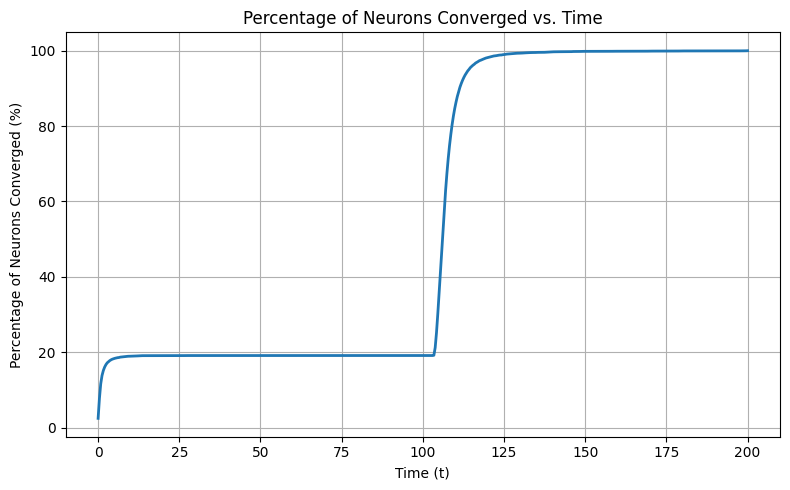

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm


# -----------------------------------------------------------------
# Set integration parameters for a fixed grid of neurons.
# -----------------------------------------------------------------
tf_single = 200
t_eval_single = np.linspace(0, tf_single, 500)

# Define a fixed grid of neurons.
nb_of_points_grid = 100  # Change as needed
x1p_values = np.linspace(0, 10, nb_of_points_grid)
x1n_values = np.linspace(0, 10, nb_of_points_grid)
all_neurons = [(x1p, x1n) for x1p in x1p_values for x1n in x1n_values]

tol = 1e-3  # tolerance level to consider a neuron converged

# -----------------------------------------------------------------
# Compute convergence times for each neuron.
# -----------------------------------------------------------------
convergence_times = []  # list to store convergence time for each neuron

print(f"Computing convergence times for grid with {nb_of_points_grid**2} neurons...")
for x1p, x1n in tqdm(all_neurons, total=len(all_neurons), desc="Integrating neurons"):
    sol = solve_ivp(dy_dt, (0, tf_single), [1e-6],
                    args=(delta, x1p, x1n, k_s),
                    t_eval=t_eval_single,
                    method="RK45", rtol=1e-8, atol=1e-10)
    y_vals = sol.y[0]

    # Define the steady state value as the final value from the integration.
    y_final = y_vals[-1]
    conv_time = tf_single  # default value if neuron doesn't converge early
    for t_val, y_val in zip(sol.t, y_vals):
        if abs(y_val - y_final) < tol:
            conv_time = t_val
            break
    convergence_times.append(conv_time)

convergence_times = np.array(convergence_times)

# -----------------------------------------------------------------
# Compute the percentage of neurons converged as a function of time.
# For a set of time points, count the fraction of neurons that have converged.
# -----------------------------------------------------------------
time_grid = np.linspace(0, tf_single, 500)
percentage_converged = []

for t in time_grid:
    # Count neurons with convergence time less than or equal to t.
    count = np.sum(convergence_times <= t)
    percentage = 100 * count / len(convergence_times)
    percentage_converged.append(percentage)

# -----------------------------------------------------------------
# Plot the percentage of neurons converged as a function of time.
# -----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time_grid, percentage_converged, lw=2)
ax.set_xlabel("Time (t)")
ax.set_ylabel("Percentage of Neurons Converged (%)")
ax.set_title("Percentage of Neurons Converged vs. Time")
ax.grid(True)
plt.tight_layout()
plt.show()



It seems that there is a phase transition. We should not be surprized, as all is deterministic, all neurones takes roughly the same time scale to reach the decided state.